In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
        UpSampling2D, Lambda, Activation, merge
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz

Using TensorFlow backend.


In [2]:
#Load dataset
x_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')
x_validate = np.load('data/x_validate.npy')
y_validate = np.load('data/y_validate.npy')

In [3]:
output_shape = y_train[0].shape
num_images = y_train.shape[0]

In [4]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', act=True):
    x = Conv2D(filters, (size,size), strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if act == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=64):
    x = convolution_block(blockInput, num_filters, 3)
    x = convolution_block(x, num_filters, 3, act=False)
    x = merge([x, blockInput], mode='sum')
    return x

def upsampling_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, (size,size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [5]:
'''NETWORK #1'''
inp=Input(x_train.shape[1:])
x=convolution_block(inp, 64, 9)
x=residual_block(x)
x=residual_block(x)
x=residual_block(x)
x=residual_block(x)
#x=upsampling_block(x, 64, 3)
#x=upsampling_block(x, 64, 3)
#n1_out=convolution_block(x, 3, 9)
x=Conv2D(3, (9,9), activation='tanh', padding='same')(x)
n1_out=Lambda(lambda x: (x+1)*127.5)(x) #scale output so we get 0 to 255

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [ ]:
'''NETWORK #2 - VGG'''
#We want to use VGG so that we know the difference in activation between
#high-res image and output of the low-res image
#High-res -> VGG -> high-res activation
#Low-res -> trainableCNN -> VGG -> generated image activation

#Note that there are 2 inputs for VGG network:
#   1. Output of the low-res image from trainable network
#   2. High-res image

'''VGG input preprocessing as stated in the paper'''
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preprocess_vgg = lambda x: (x - vgg_mean)[:, :, :, ::-1]

vgg_inp=Input(output_shape)
vgg= VGG16(include_top=False, input_tensor=Lambda(preprocess_vgg)(vgg_inp))

for layer in vgg.layers: 
    layer.trainable=False

#Note that we want the activation from early layers
#Recall from style transfer paper:
#Early conv layers gives clearer contents

def get_output(m, ln):
    name = 'block' + str(ln) + '_conv1'
    return m.get_layer(name).output

#Define model that will grab the activations from first 3 conv layers
vgg_content = Model(vgg_inp, [get_output(vgg, o) for o in [1,2,3]])

#vgg1 = for the high res image
vgg1 = vgg_content(vgg_inp)

#vgg2 = for the generated image
vgg2 = vgg_content(n1_out)

In [6]:
def mean_squared_error(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

layer_weights=[0.3, 0.65, 0.05]
def content_fn(x):
    res = 0
    n=len(layer_weights)
    for i in range(n):
        res += mean_squared_error(x[i]-x[i+n]) * layer_weights[i]
    return res

In [ ]:
#Define the model that actually minimizes the loss
model = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
#We want the output of our model (loss) to be zeros
target = np.zeros((num_images, 1))
target_val = np.zeros((x_validate.shape[0], 1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
#model.optimizer=Adam(0.0001)
#model.fit([x_train,y_train], target, batch_size=3, epochs=1000, shuffle=True,
#          validation_data=([x_validate,y_validate],target_val))

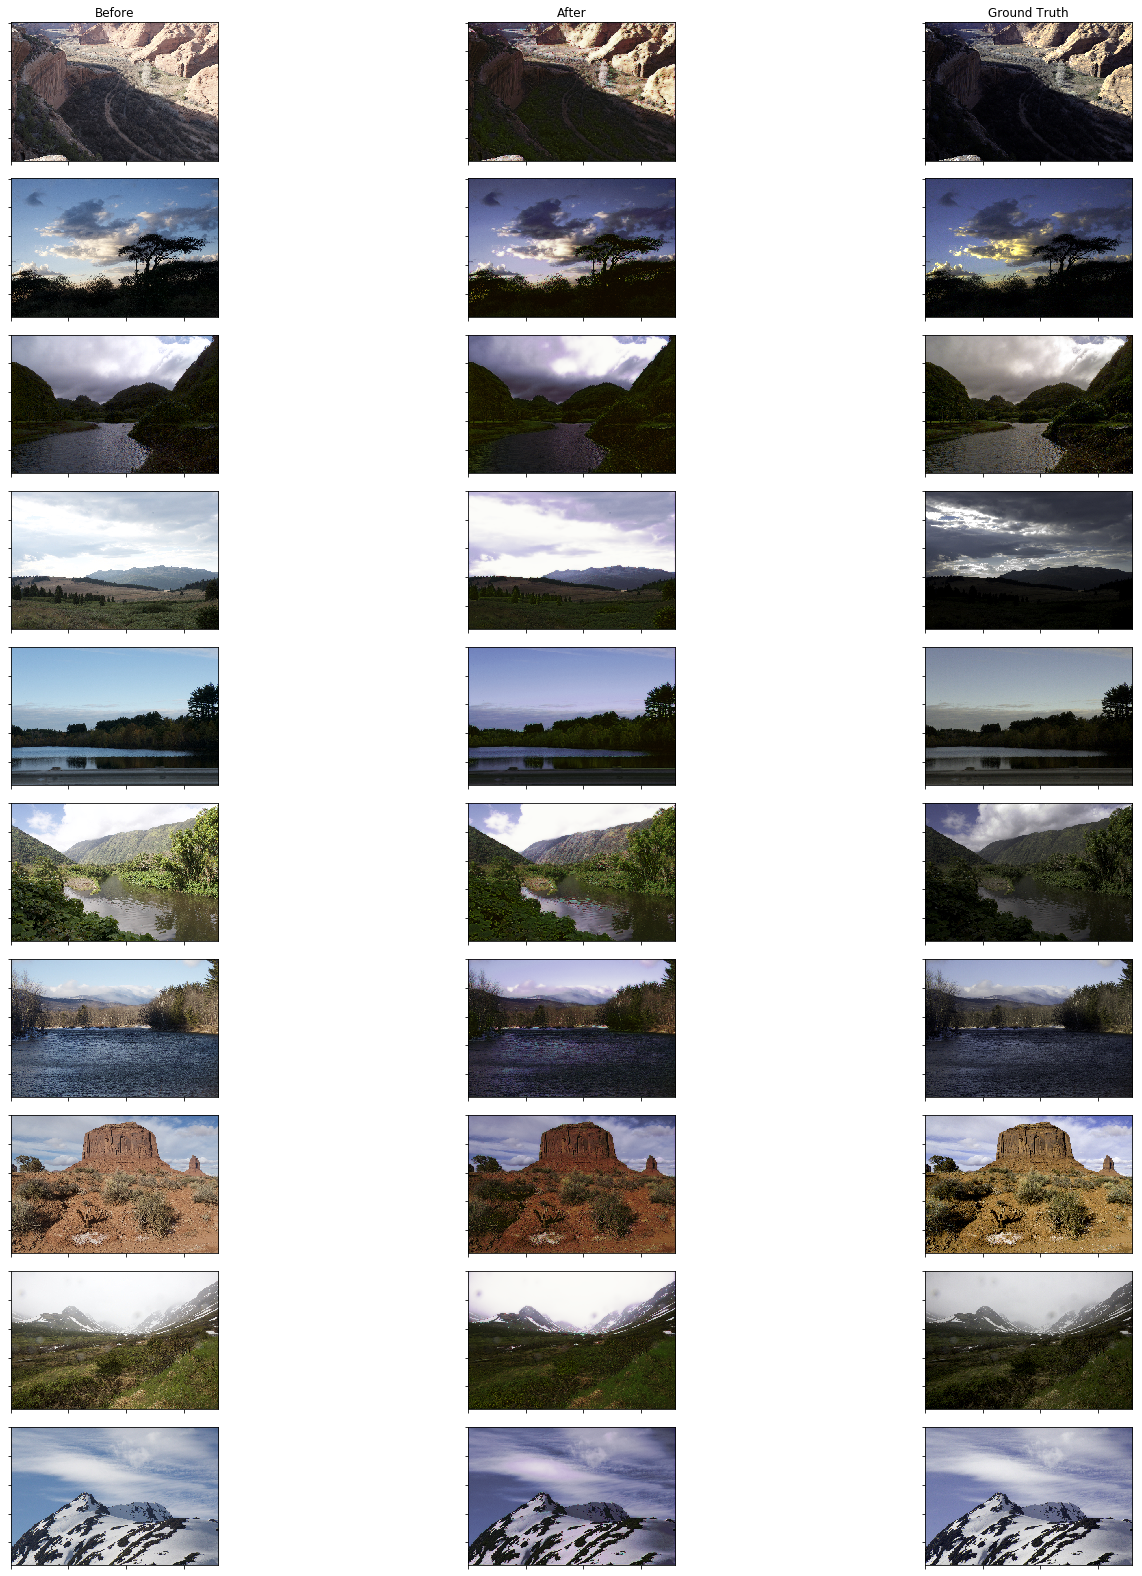

In [7]:
num=10

#Define the trained model
trained_model = Model(inp, n1_out)
trained_model.load_weights('model32_validated_500epochs.h5')

#Let's predict the first 3 images in our dataset
predictions = trained_model.predict(x_train[:num])

i = 0
#single_prediction = predictions[i].astype('uint8')
#imsave('before.jpg',x_train[i])
#imsave('after.jpg',single_prediction)

columns = ['{}'.format(col) for col in ['Before', 'After', 'Ground Truth']]

fig,axis = plt.subplots(nrows=num, ncols=3, figsize=(22,22))

for ax,col in zip(axis[0], columns):
    ax.set_title(col)

for i in range(num):
    axis[i,0].imshow(Image.fromarray(x_train[i].astype('uint8')))
    axis[i,1].imshow(Image.fromarray(predictions[i].astype('uint8')))
    axis[i,2].imshow(Image.fromarray(y_train[i].astype('uint8')))
    axis[i,0].set_yticklabels([])
    axis[i,0].set_xticklabels([])
    axis[i,1].set_yticklabels([])
    axis[i,1].set_xticklabels([])
    axis[i,2].set_yticklabels([])
    axis[i,2].set_xticklabels([])

plt.tight_layout()
plt.show()

In [9]:
im = Image.open('before.jpg')
im = im.resize((720,480))
im = np.asarray(im)
im = np.expand_dims(im,axis=0)
p = trained_model.predict(im)

gimp = Image.open('after_GIMP_autoenhance.jpg')
gimp = np.asarray(gimp)
gimp = np.expand_dims(gimp,axis=0)

post = Image.open('after_post.jpg')
post = np.asarray(post)
post = np.expand_dims(post,axis=0)

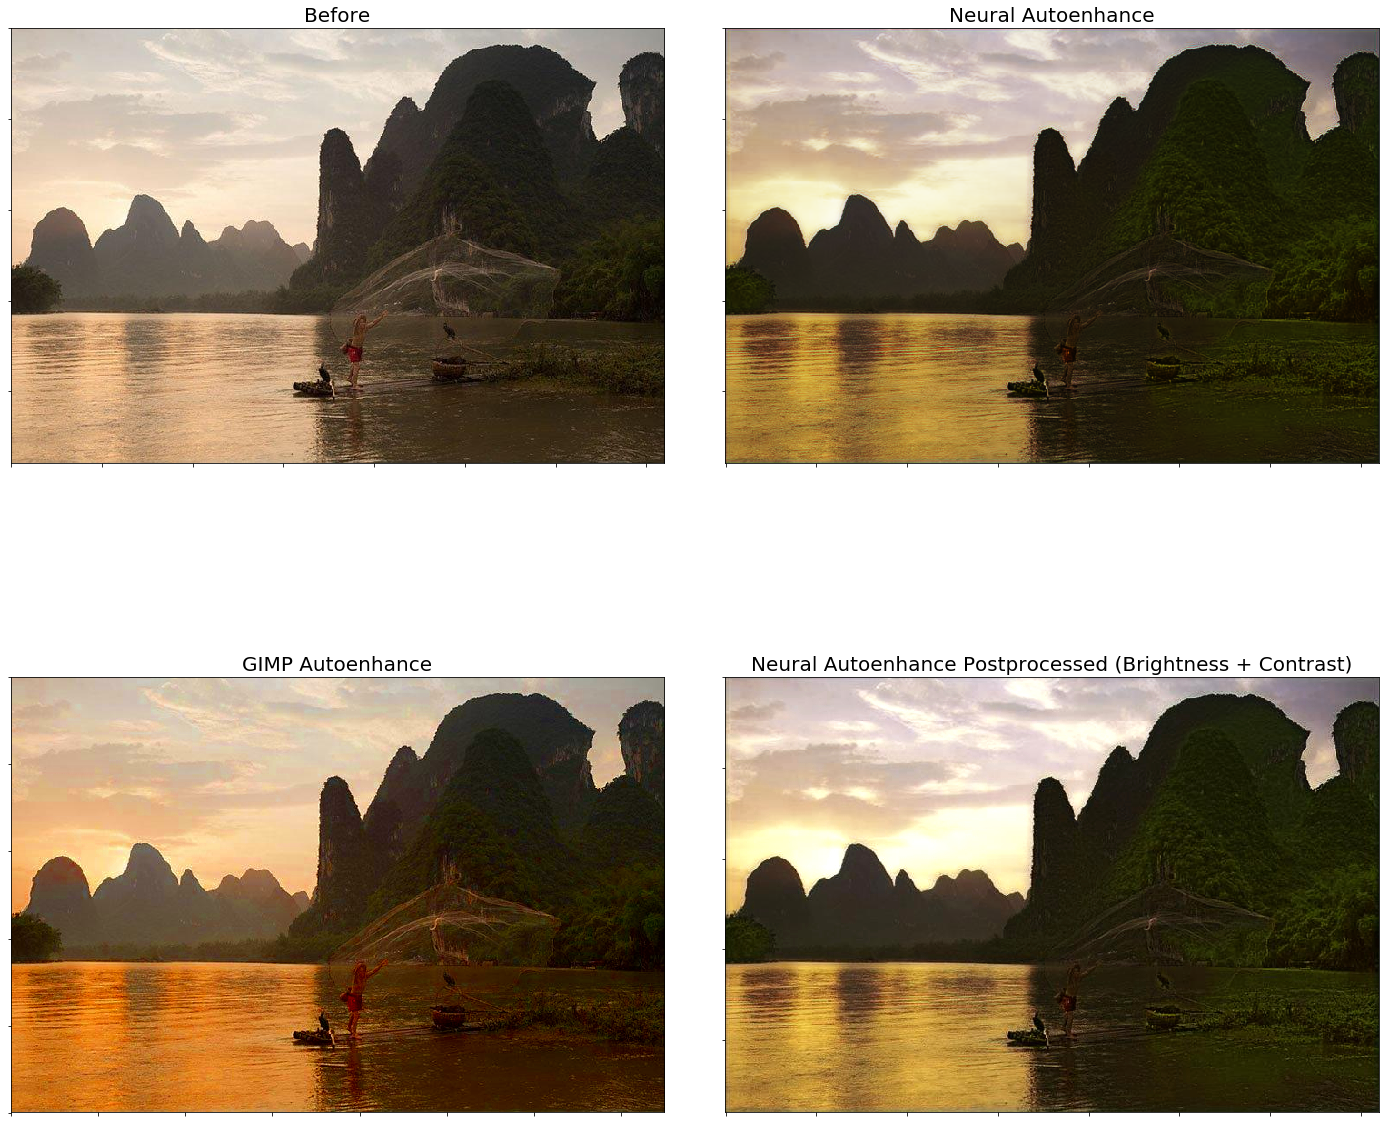

In [10]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
axes[0,0].set_title('Before',fontsize=20)
axes[0,0].imshow(im[0])
axes[0,0].set_yticklabels([])
axes[0,0].set_xticklabels([])
axes[0,1].set_title('Neural Autoenhance',fontsize=20)
axes[0,1].imshow(p[0].astype('uint8'))
axes[0,1].set_yticklabels([])
axes[0,1].set_xticklabels([])
axes[1,0].set_title('GIMP Autoenhance',fontsize=20)
axes[1,0].imshow(gimp[0].astype('uint8'))
axes[1,0].set_yticklabels([])
axes[1,0].set_xticklabels([])
axes[1,1].set_title('Neural Autoenhance Postprocessed (Brightness + Contrast)',fontsize=20)
axes[1,1].imshow(post[0].astype('uint8'))
axes[1,1].set_yticklabels([])
axes[1,1].set_xticklabels([])
plt.tight_layout()
plt.show()

In [ ]:
#trained_model.save_weights('model32_validated_500epochs.h5')